# Module 2 - TOP500 Data Exercises (Revised)

This notebook provides hands-on exercises for analyzing the TOP500 dataset with a DOE/NERCS lens.
All examples assume you have a CSV file at: `data/TOP500_202506.csv`.

If your CSV has slightly different column names, the helper functions below will auto-detect the best matches.


In [1]:
# ---- Setup (Matplotlib + Pandas) ----
import pandas as pd
import matplotlib.pyplot as plt
import re

# Plot defaults (single-plot style)
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

def normalize(s: str) -> str:
    """Lowercase, remove brackets/parentheses, collapse spaces/underscores."""
    s = str(s)
    s = s.lower().replace("\u202f", " ")
    s = re.sub(r"[()\[\]]", "", s)
    s = re.sub(r"[_\s]+", " ", s).strip()
    return s

def find_col(cols, must_include):
    """Find first column whose normalized name contains all tokens in must_include."""
    ncols = {c: normalize(c) for c in cols}
    for c, n in ncols.items():
        if all(tok in n for tok in must_include):
            return c
    return None

def coerce_numeric(series):
    """Turn strings like '1,234.5' or '1 234.5' into floats; keep NaN if not parseable."""
    return pd.to_numeric(
        series.astype(str)
              .str.replace("\u202f", "", regex=False)
              .str.replace(",", "", regex=False)
              .str.replace(" ", "", regex=False),
        errors="coerce"
    )


In [2]:
# ---- Load Data ----
DATA_PATH = "data/TOP500_202506.csv"  # Adjust if needed
df = pd.read_csv(DATA_PATH)

# Identify key columns robustly (works across minor header variations)
name_col    = find_col(df.columns, ["name"]) or find_col(df.columns, ["system", "name"]) or find_col(df.columns, ["system"])
site_col    = find_col(df.columns, ["site", "id"])  # fallback
country_col = find_col(df.columns, ["country"])
vendor_col  = find_col(df.columns, ["vendor"]) or find_col(df.columns, ["manufacturer"])
rmax_col    = find_col(df.columns, ["rmax", "flop"]) or find_col(df.columns, ["r max", "flop"])
rpeak_col   = find_col(df.columns, ["rpeak", "flop"]) or find_col(df.columns, ["r peak", "flop"])
power_col   = find_col(df.columns, ["power", "kw"]) or find_col(df.columns, ["power"])  # sometimes just Power
accel_cores_col = find_col(df.columns, ["accelerator", "cores"]) or find_col(df.columns, ["gpu", "cores"])
total_cores_col = find_col(df.columns, ["cores"])  # generic fall-back

# Fill names from site if missing
if name_col is None and site_col is not None:
    name_col = site_col
elif name_col is not None and site_col is not None:
    df[name_col] = df[name_col].fillna(df[site_col])

# Coerce numerics where present
for col in [rmax_col, rpeak_col, power_col, accel_cores_col, total_cores_col]:
    if col in df.columns:
        df[col] = coerce_numeric(df[col])

print("Detected columns ->",
      "\n  name_col:", name_col,
      "\n  country_col:", country_col,
      "\n  vendor_col:", vendor_col,
      "\n  rmax_col:", rmax_col,
      "\n  rpeak_col:", rpeak_col,
      "\n  power_col:", power_col,
      "\n  accel_cores_col:", accel_cores_col,
      "\n  total_cores_col:", total_cores_col)

df.head(3)


Detected columns -> 
  name_col: Name 
  country_col: Country 
  vendor_col: Manufacturer 
  rmax_col: Rmax [TFlop/s] 
  rpeak_col: Rpeak [TFlop/s] 
  power_col: Power (kW) 
  accel_cores_col: Accelerator/Co-Processor Cores 
  total_cores_col: Total Cores


,Rank,Previous Rank,First Appearance,First Rank,Name,Computer,Site,Manufacturer,Country,Year,...,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Model,System Family,Interconnect Family,Interconnect,Continent,Site ID,System ID
0,1,1.0,64,1,El Capitan,"HPE Cray EX255a, AMD 4th Gen EPYC 24C 1.8GHz, ...",DOE/NNSA/LLNL,HPE,United States,2024,...,AMD Instinct MI300A,24,AMD Zen-4 (Genoa),HPE Cray EX255a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,"49,763",180307
1,2,2.0,59,1,Frontier,"HPE Cray EX235a, AMD Optimized 3rd Generation ...",DOE/SC/Oak Ridge National Laboratory,HPE,United States,2021,...,AMD Instinct MI250X,64,AMD Zen-3 (Milan),HPE Cray EX235a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,"48,553",180047
2,3,3.0,62,2,Aurora,"HPE Cray EX - Intel Exascale Compute Blade, Xe...",DOE/SC/Argonne National Laboratory,Intel,United States,2023,...,Intel Data Center GPU Max,52,Intel Xeon Max,HPE Cray EX - Intel Exascale Compute Blade,HPE Cray EX - Intel Exascale Compute Blade,Gigabit Ethernet,Slingshot-11,North America,"47,347",180183


## Exercise 1 - Performance Rankings and Trends

Objectives:
1) Find the top 5 systems by Rmax and by Rpeak.
2) Compare the two rankings (who wins by Rmax vs Rpeak?).
3) Plot the Top 10 by Rmax as a horizontal bar chart.

In this step, we explore which systems lead the TOP500 list in terms of raw computational performance.

**What this code does:**

1. **Check for `Rmax` availability** — `Rmax` represents the measured performance of a system in TeraFLOP/s or PetaFLOP/s during the LINPACK benchmark.  
   If this column is missing, the analysis cannot proceed, so we stop with an error.

2. **Rank systems by `Rmax`** — We:
   - Remove rows with missing `Rmax` values.
   - Sort the remaining systems in descending order of `Rmax`.
   - Select the **top 5** to display in a table.

3. **Optionally rank by `Rpeak`** — `Rpeak` is the theoretical maximum performance of a system based on its hardware specifications.  
   If present, we repeat the same process to find the top 5 by `Rpeak`.

4. **Display results** — We use `IPython.display` for a cleaner table in notebooks, but also include a fallback `print` for non-notebook environments.

5. **Visualize the top performers** — To give a more intuitive sense of performance distribution, we:
   - Select the **top 10** systems by `Rmax`.
   - Create a horizontal bar chart with `Rmax` on the x-axis and system names on the y-axis.
   - Invert the y-axis so the top system appears at the top of the chart.

**Why this matters in the DOE HPC Bootcamp context:**  
Understanding which systems lead in *measured* performance vs *theoretical* performance gives insights into:
- The efficiency of system designs.
- The role of software and workload optimization.
- How real-world benchmarking can differ from hardware specifications.

This forms the foundation for later exercises on **energy efficiency** and **accelerator usage**, where performance must be balanced against power consumption.



Top 5 by Rmax:


,Name,Rmax [TFlop/s]
0,El Capitan,1742000.0
1,Frontier,1353000.0
2,Aurora,1012000.0
3,JUPITER Booster,793400.0
4,Eagle,561200.0



Top 5 by Rpeak:


,Name,Rpeak [TFlop/s]
0,El Capitan,2746376.09
1,Frontier,2055716.99
2,Aurora,1980006.00
3,JUPITER Booster,930000.00
4,Eagle,846835.20


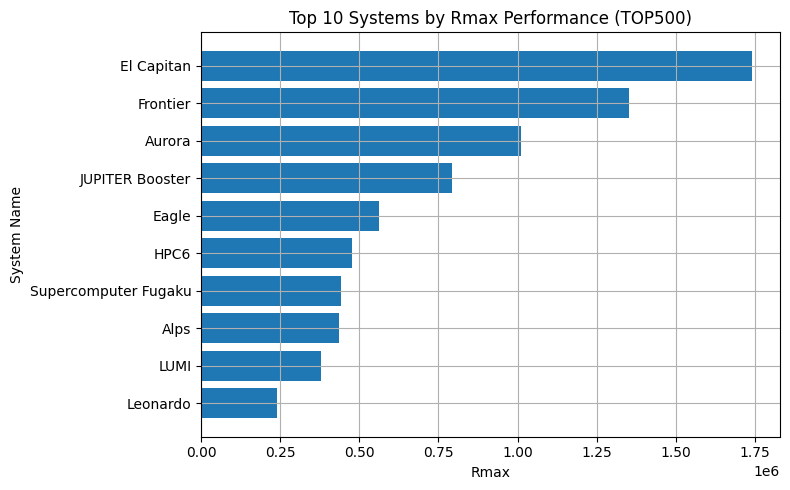

In [9]:
# --- Your Work: Top systems by Rmax and Rpeak ---
if rmax_col is None:
    raise KeyError("Couldn't find an Rmax-like column in your CSV.")
top5_rmax = df.dropna(subset=[rmax_col]).sort_values(rmax_col, ascending=False).head(5)

if rpeak_col is not None:
    top5_rpeak = df.dropna(subset=[rpeak_col]).sort_values(rpeak_col, ascending=False).head(5)
else:
    top5_rpeak = pd.DataFrame()

print("Top 5 by Rmax:")
try:
    from IPython.display import display
    display(top5_rmax[[name_col, rmax_col]].reset_index(drop=True))
except Exception:
    print(top5_rmax[[name_col, rmax_col]].reset_index(drop=True))

if not top5_rpeak.empty:
    print("\nTop 5 by Rpeak:")
    try:
        display(top5_rpeak[[name_col, rpeak_col]].reset_index(drop=True))
    except Exception:
        print(top5_rpeak[[name_col, rpeak_col]].reset_index(drop=True))
else:
    print("\nRpeak column not available in this CSV.")

# --- Plot: Top 10 by Rmax ---
top10 = df.dropna(subset=[rmax_col]).sort_values(rmax_col, ascending=False).head(10)
plt.figure()
plt.barh(top10[name_col], top10[rmax_col])
plt.gca().invert_yaxis()
plt.xlabel("Rmax")
plt.ylabel("System Name")
plt.title("Top 10 Systems by Rmax Performance (TOP500)")
plt.tight_layout()
plt.show()


## Exercise 2 - Energy Efficiency
Objectives:
1) Compute performance per watt (use Rmax / Power).
2) Identify the top 10 most efficient systems.
3) Make a scatter plot of Rmax vs Power, and discuss outliers.

High performance is valuable, but in DOE HPC systems, **performance per watt** is equally critical due to facility power limits, cost, and sustainability goals.  
In this step, we evaluate how efficiently each supercomputer converts electrical power into computational performance.

**What this code does:**

1. **Check for power data** — If the dataset lacks a power consumption column, the analysis is skipped.  
   This prevents errors and makes the workflow adaptable to datasets with varying levels of detail.

2. **Prepare a working copy** — We duplicate the dataset into `df_eff` so the original `df` remains unchanged for future steps.

3. **Filter valid rows** — Systems must have a non-missing, non-zero power value to be included. This avoids division errors and misleading results.

4. **Calculate efficiency** —  
   - We create a new column `efficiency_perf_per_kw` as:
     \[
     \text{Efficiency} = \frac{\text{Rmax}}{\text{Power (kW)}}
     \]
   - This metric represents *measured performance per kilowatt*.

5. **Identify the leaders** — We sort systems by this efficiency metric and display the **Top 10** most efficient systems, including their:
   - Name
   - Rmax
   - Power consumption
   - Efficiency value

6. **Visualize the relationship** —  
   - A scatter plot of `Rmax` (x-axis) vs `Power (kW)` (y-axis) shows the performance–power tradeoff.  
   - Clusters can reveal architectural patterns, and outliers may indicate exceptionally efficient or inefficient systems.

**Why this matters in the DOE HPC Bootcamp context:**  
DOE facilities operate under strict energy budgets, often in the tens of megawatts.  
By focusing on *performance per watt*, we connect raw HPC capability to real-world constraints in system design, procurement, and operation. This metric also foreshadows our upcoming analysis on **accelerator usage** and **vendor architectures**, which often directly influence efficiency.



Top 10 by Rmax per kW:


,Name,Rmax [TFlop/s],Power (kW),efficiency_perf_per_kw
0,Adastra 2,2529.0,36.60,69.098361
1,JEDI,4504.0,67.31,66.914277
2,Henri,2882.0,44.07,65.395961
3,Portage,24100.0,371.48,64.875633
4,Hunter,31680.0,490.00,64.653061
5,Isambard-AI phase 1,7417.0,117.08,63.349846
6,HoreKa-Teal,3123.0,49.60,62.963710
7,rzAdams,24380.0,388.20,62.802679
8,Frontier TDS,19200.0,308.68,62.200337
9,Viper-GPU,31096.0,499.98,62.194488


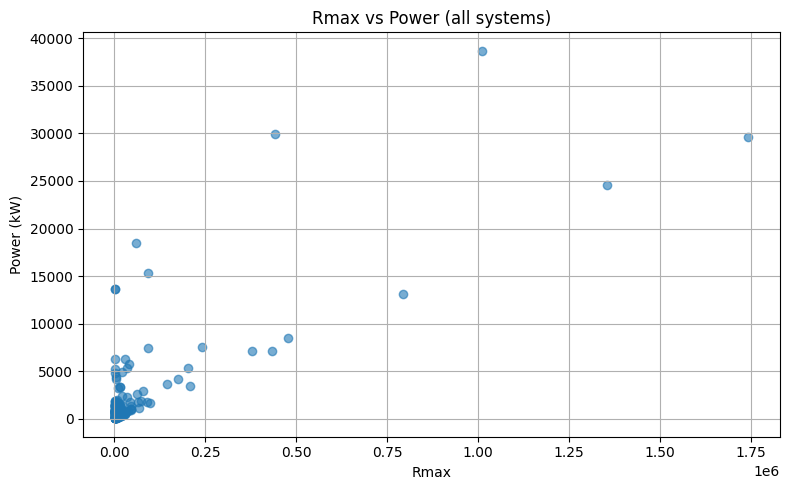

In [4]:
# --- Your Work: Efficiency metric ---
if power_col is None:
    print("No power column detected; skipping efficiency analysis.")
else:
    eff_col = "efficiency_perf_per_kw"
    df_eff = df.copy()
    # Avoid division by zero
    df_eff = df_eff[(df_eff[power_col].notna()) & (df_eff[power_col] > 0)]
    df_eff[eff_col] = df_eff[rmax_col] / df_eff[power_col]

    # Top 10 efficient systems
    top_eff = df_eff.sort_values(eff_col, ascending=False).head(10)
    print("Top 10 by Rmax per kW:")
    try:
        from IPython.display import display
        display(top_eff[[name_col, rmax_col, power_col, eff_col]].reset_index(drop=True))
    except Exception:
        print(top_eff[[name_col, rmax_col, power_col, eff_col]].reset_index(drop=True))

    # Scatter plot: Rmax vs Power
    plt.figure()
    plt.scatter(df_eff[rmax_col], df_eff[power_col], alpha=0.6)
    plt.xlabel("Rmax")
    plt.ylabel("Power (kW)")
    plt.title("Rmax vs Power (all systems)")
    plt.tight_layout()
    plt.show()


## Exercise 3 - Accelerator (GPU) Usage
Objectives:
1) Estimate the fraction of accelerator cores for each system.
2) Compare average efficiency between accelerated vs non-accelerated systems.
3) Plot a histogram of accelerator-core fractions.


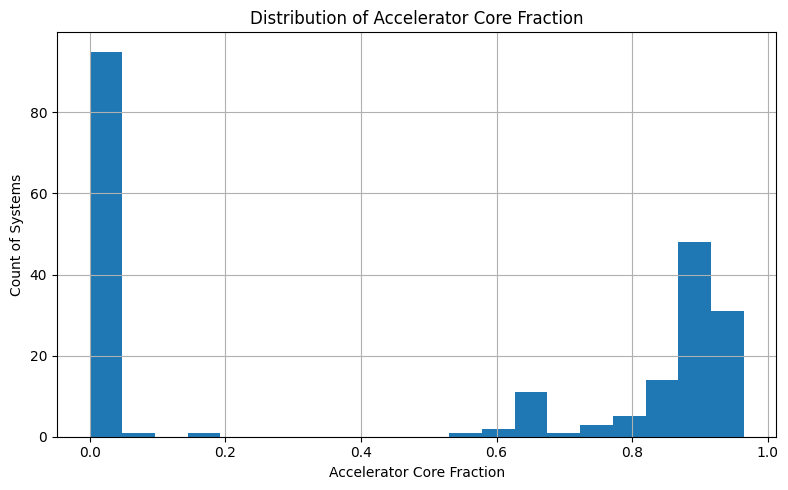

Avg efficiency (accelerated):   35.9
Avg efficiency (non-accelerated): 5.32


In [5]:
# --- Your Work: Accelerator fraction & comparison ---
if accel_cores_col and total_cores_col and power_col:
    tmp = df.copy()
    tmp = tmp[(tmp[total_cores_col].notna()) & (tmp[total_cores_col] > 0)]
    tmp["accel_frac"] = (tmp[accel_cores_col].fillna(0)) / tmp[total_cores_col]

    # Reuse efficiency metric if available
    tmp = tmp[(tmp[power_col].notna()) & (tmp[power_col] > 0)]
    tmp["efficiency_perf_per_kw"] = tmp[rmax_col] / tmp[power_col]

    # Histogram of accelerator fraction
    plt.figure()
    plt.hist(tmp["accel_frac"].dropna(), bins=20)
    plt.xlabel("Accelerator Core Fraction")
    plt.ylabel("Count of Systems")
    plt.title("Distribution of Accelerator Core Fraction")
    plt.tight_layout()
    plt.show()

    # Compare efficiency by acceleration
    is_accel = tmp["accel_frac"] > 0
    eff_accel = tmp.loc[is_accel, "efficiency_perf_per_kw"].mean()
    eff_noacc = tmp.loc[~is_accel, "efficiency_perf_per_kw"].mean()
    print(f"Avg efficiency (accelerated):   {eff_accel:.3g}")
    print(f"Avg efficiency (non-accelerated): {eff_noacc:.3g}")
else:
    print("Needed columns for accelerator analysis not found; skipping.")


### Exercise 4 – Geographic Distribution of HPC Systems

Objectives:
1) Count systems per country and plot the top N countries.
2) Compare each country's total Rmax share of the list.
3) Discuss which regions lead, and why (policy, funding, industry?).

HPC is a global endeavor, and the location of systems reflects each country’s investment in scientific research, industry, and national security.  
In this step, we examine where the top-performing systems are located and how total performance is distributed geographically.

**What this code does:**

1. **Check for country data** — If the dataset includes a country column, we can analyze geographic patterns; otherwise, this section is skipped.

2. **Count systems per country** —  
   - We group the dataset by country.
   - Count the number of systems in each country.
   - Sort in descending order.
   - Select the **top 12** countries for visualization.

3. **Visualize system counts** —  
   A horizontal bar chart shows the number of systems in the top 12 countries, with the largest counts at the top.

4. **Total Rmax per country** —  
   If `Rmax` data is available:
   - We sum the `Rmax` values for each country.
   - Sort and select the **top 12**.
   - Plot another horizontal bar chart to show total measured performance by country.

**Why this matters in the DOE HPC Bootcamp context:**  
Geographic distribution analysis highlights:
- Which nations have the largest HPC infrastructures.
- How performance is concentrated or distributed globally.
- The potential for international collaboration or competition in scientific computing.

For DOE participants, this provides a broader context for where U.S. systems fit into the global HPC landscape, both in terms of **number of systems** and **aggregate performance**.



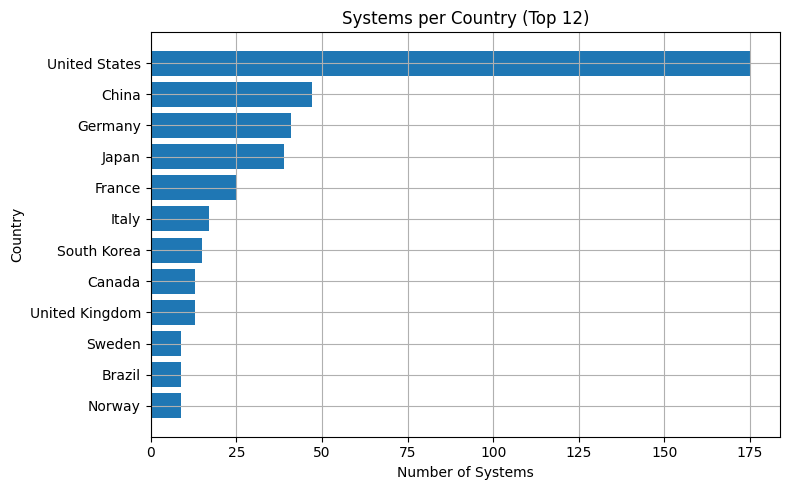

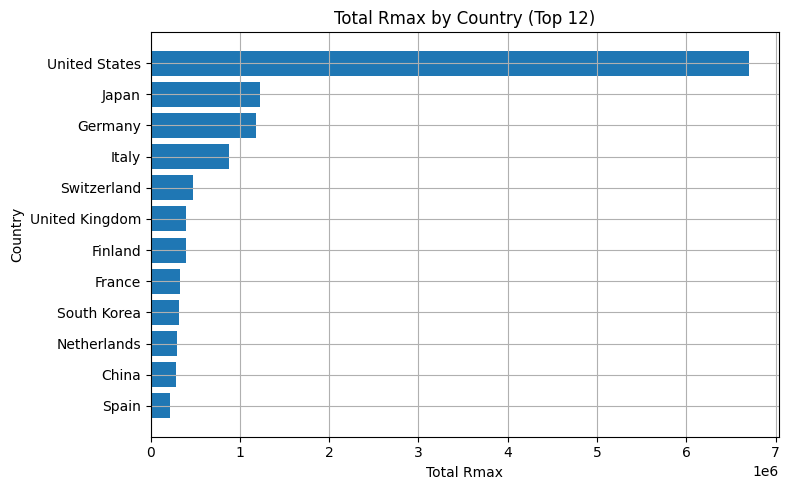

In [11]:
# --- Your Work: Country distribution ---
if country_col is not None:
    count_by_country = df.groupby(country_col, dropna=False).size().sort_values(ascending=False)
    topn = count_by_country.head(12)

    plt.figure()
    plt.barh(topn.index.astype(str), topn.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Number of Systems")
    plt.ylabel("Country")
    plt.title("Systems per Country (Top 12)")
    plt.tight_layout()
    plt.show()

    if rmax_col is not None:
        rmax_by_country = df.groupby(country_col, dropna=False)[rmax_col].sum().sort_values(ascending=False).head(12)
        plt.figure()
        plt.barh(rmax_by_country.index.astype(str), rmax_by_country.values)
        plt.gca().invert_yaxis()
        plt.xlabel("Total Rmax")
        plt.ylabel("Country")
        plt.title("Total Rmax by Country (Top 12)")
        plt.tight_layout()
        plt.show()
else:
    print("No country column detected; skipping geographic distribution.")


## Exercise 5 - Vendor / Architecture Analysis
Objectives:
1) Group by vendor/manufacturer and compute average Rmax and average efficiency.
2) Plot the top vendors by average efficiency and discuss tradeoffs.
3) If a CPU model column exists, drill down to compare CPU families.


,Rmax [TFlop/s],efficiency_perf_per_kw
Manufacturer,,
Intel,1.012000e+06,26.150979
Nebius AI,1.244700e+05,36.723128
IBM / NVIDIA / Mellanox,9.464000e+04,12.723372
NRCPC,9.301459e+04,6.051304
HPE,7.987891e+04,27.677867
NUDT,6.144450e+04,3.324559
Fujitsu,4.990043e+04,17.935454
ASUSTeK,4.582000e+04,42.976261
EVIDEN,4.041491e+04,19.315827


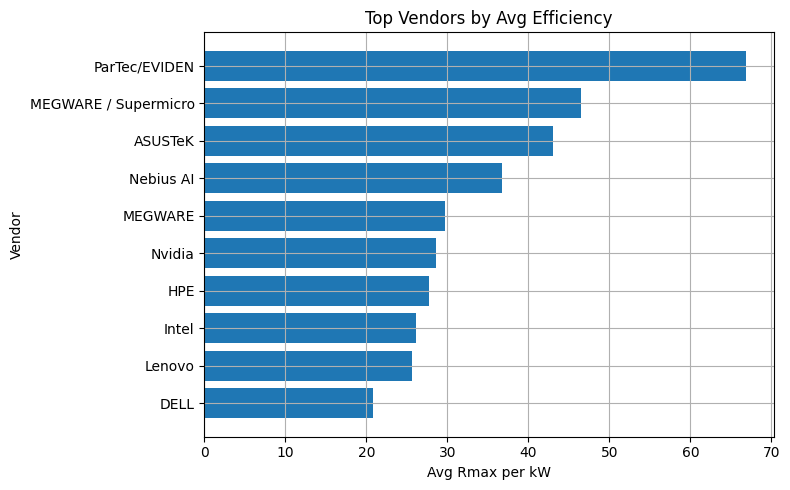

In [7]:
# --- Your Work: Vendor-level metrics ---
if vendor_col is not None:
    work = df.copy()
    # Compute efficiency if possible
    if power_col is not None:
        work = work[(work[power_col].notna()) & (work[power_col] > 0)]
        work["efficiency_perf_per_kw"] = work[rmax_col] / work[power_col]

    agg_dict = {rmax_col: "mean"}
    if "efficiency_perf_per_kw" in work.columns:
        agg_dict["efficiency_perf_per_kw"] = "mean"

    vendor_stats = work.groupby(vendor_col).agg(agg_dict).sort_values(rmax_col, ascending=False)
    try:
        from IPython.display import display
        display(vendor_stats.head(10))
    except Exception:
        print(vendor_stats.head(10))

    # Plot by efficiency if available
    if "efficiency_perf_per_kw" in vendor_stats.columns:
        top_eff = vendor_stats.sort_values("efficiency_perf_per_kw", ascending=False).head(10)
        plt.figure()
        plt.barh(top_eff.index.astype(str), top_eff["efficiency_perf_per_kw"].values)
        plt.gca().invert_yaxis()
        plt.xlabel("Avg Rmax per kW")
        plt.ylabel("Vendor")
        plt.title("Top Vendors by Avg Efficiency")
        plt.tight_layout()
        plt.show()
else:
    print("No vendor/manufacturer column detected; skipping vendor analysis.")


## (Optional) Exercise 6 - Trend Over Lists/Years
If your CSV includes a list index or year column (e.g., Year, List, Publication Year), analyze how the top system has changed over time:
- Plot the top system's Rmax vs year.
- Discuss whether growth appears to be saturating or accelerating.


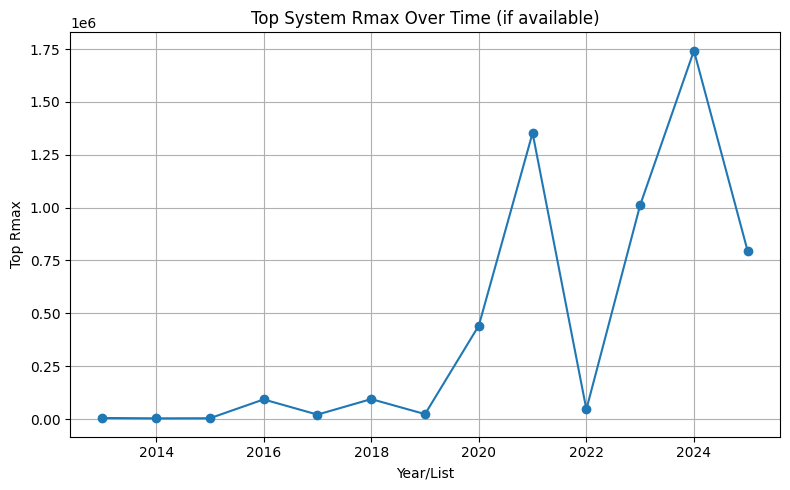

In [8]:
# --- Your Work: Time trend (if columns exist) ---
year_col = find_col(df.columns, ["year"]) or find_col(df.columns, ["list"]) or find_col(df.columns, ["publication", "year"])
if year_col is not None and rmax_col is not None:
    # Coerce year to numeric if needed
    df[year_col] = coerce_numeric(df[year_col])
    top_by_year = (df.dropna(subset=[year_col, rmax_col])
                     .sort_values([year_col, rmax_col], ascending=[True, False])
                     .groupby(year_col, as_index=False)
                     .first())
    plt.figure()
    plt.plot(top_by_year[year_col], top_by_year[rmax_col], marker="o")
    plt.xlabel("Year/List")
    plt.ylabel("Top Rmax")
    plt.title("Top System Rmax Over Time (if available)")
    plt.tight_layout()
    plt.show()
else:
    print("No year/list column detected; skipping time-trend exercise.")


---

Submission / Discussion Prompts
- Which systems (or vendors) deliver the best performance per watt?
- Do countries with more systems also dominate total Rmax?
- How strongly does accelerator fraction correlate with efficiency in your results?
- If you had budget and power constraints, what procurement strategy would you propose for a new DOE system?

Keep notes on any assumptions about column names/units and how you validated them.
